# Investigating the correlation between plant pairs (related by genus) and their geolocation 

### Import modules

In [1]:
import logging
from collections import defaultdict
import json
import pandas as pd
from tqdm import tqdm
    
# Stats
from scipy.stats import pearsonr
from statannot import add_stat_annotation
import ptitprince as pt

# Viz
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt

/Users/danieldomingo/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
%matplotlib inline

In [3]:
logging.disable()
pd.options.mode.chained_assignment = None

In [4]:
DATA_DIR = '../data/processed'

### Load plant-disease evidences

In [5]:
literature_pairs = pd.read_csv(
    f'{DATA_DIR}/literature_based_correlation_data.tsv',
    sep='\t'
)

,plant_1,plant_2,pair_type,pearson_coefficient
0,ncbitaxon:224826,ncbitaxon:90897,Same genus,-0.065795
1,ncbitaxon:182999,ncbitaxon:185140,Same genus,0.912211
2,ncbitaxon:3685,ncbitaxon:159421,Same genus,-0.045455
3,ncbitaxon:3685,ncbitaxon:159425,Same genus,-0.079517
4,ncbitaxon:3685,ncbitaxon:159422,Same genus,0.340272
...,...,...,...,...
315862,ncbitaxon:209099,ncbitaxon:226103,Random,-0.132314
315863,ncbitaxon:205558,ncbitaxon:3617,Random,-0.155268
315864,ncbitaxon:3485,ncbitaxon:282756,Random,0.266265
315865,ncbitaxon:483859,ncbitaxon:67938,Random,0.847669


In [6]:
literature_pairs_genus = literature_pairs[literature_pairs['pair_type'] == 'Same genus']

In [7]:
medicinal_plants_lit = set(literature_pairs_genus['plant_1'].tolist()).union(
    literature_pairs_genus['plant_2'].tolist()
)
len(medicinal_plants_lit)

3078

### Loading plant location data

In [8]:
ncbi_ids_trefle = json.load(open('../data/mapping/trefle_grounding.json'))

In [9]:
trefle_df = pd.read_csv(
    '../data/raw/trefle_species_dump.csv', 
    sep='\t', 
    usecols=['scientific_name', 'distributions']
)

In [10]:
trefle_df['scientific_name'] = trefle_df['scientific_name'].str.replace('?', '')
trefle_df['ncbi_ids'] = trefle_df['scientific_name'].map(lambda x: ncbi_ids_trefle[x][0])
trefle_df = trefle_df[trefle_df['ncbi_ids'].isin(medicinal_plants_lit)]
trefle_df.head(3)

<ipython-input-10-baba2640493b>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  trefle_df['scientific_name'] = trefle_df['scientific_name'].str.replace('?', '')


,scientific_name,distributions,ncbi_ids
0,Abies balsamea,"Alberta,Connecticut,Iowa,Labrador,Maine,Manito...",ncbitaxon:90345
4,Abies grandis,"British Columbia,California,Idaho,Montana,Oreg...",ncbitaxon:46611
29,Abutilon theophrasti,"Thailand,China North-Central,China South-Centr...",ncbitaxon:3631


In [11]:
geolocation_data = pd.read_csv(
    f'{DATA_DIR}/plant_geolocation.tsv.gz',
    compression='gzip',
    sep='\t', 
    index_col='Plant location (trefle)',
    usecols=['Plant location (trefle)', 'Country']
)
geolocation_data = geolocation_data[geolocation_data['Country'] != '-']

In [12]:
loc_info = geolocation_data.to_dict()['Country']
len(loc_info)

308

### Create location dictionary

In [13]:
plant_loc_data = defaultdict(set)
skip = set()

for _, locations, ncbi_ids in tqdm(trefle_df.values):
    if pd.isna(locations):
        continue
    for loc_name in locations.split(','):
        if loc_name not in loc_info:
            skip.add(loc_name)
            continue
        plant_loc_data[ncbi_ids].add(loc_info[loc_name])
        
len(plant_loc_data), len(skip)

100%|██████████| 4139/4139 [00:00<00:00, 65342.61it/s]


(2454, 59)

The locations that have been skipped in the previous step correspond to Islands.

### Correlation plot

In [14]:
def calculate_overlap_coefficient(elements_in_plant_1, elements_in_plant_2):
    """Calculate coeffiencient overlap."""
    if not elements_in_plant_1 or not elements_in_plant_2:
        return 0
    
    return len(
        elements_in_plant_1.intersection(elements_in_plant_2)
    ) / min([len(elements_in_plant_1), len(elements_in_plant_2)])

In [15]:
rows = []

for plant1, plant2, _, coeff in tqdm(literature_pairs_genus.values):
    if plant1 not in plant_loc_data or plant2 not in plant_loc_data:
        continue
        
    loc_plant_1 = plant_loc_data[plant1]
    loc_plant_2 = plant_loc_data[plant2]
    overlap_coeff = calculate_overlap_coefficient(loc_plant_1, loc_plant_2)
    
    if overlap_coeff == 0:
        overlap_score = 'No overlap'
    elif overlap_coeff < 0.4:
        overlap_score = 'Low'
    elif 0.4 < overlap_coeff < 0.8:
        overlap_score = 'Medium'
    else:
        overlap_score = 'High'
        
    rows.append({
        'plant_1': plant1, 
        'plant_2': plant2,
        'Geographical similarity (country overlap)': overlap_score, 
        'pearson_coefficient': coeff,
    })

100%|██████████| 10961/10961 [00:00<00:00, 84492.89it/s]


In [16]:
merged_df = pd.DataFrame(rows)

In [17]:
sns.set(context='poster')
mpl.rcParams['figure.dpi'] = 400

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

No overlap v.s. High: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.748e-06 U_stat=2.194e+06
Medium v.s. Low: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.426e-03 U_stat=8.094e+05
High v.s. Medium: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.527e+06
No overlap v.s. Medium: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.023e-05 U_stat=1.544e+06
No overlap v.s. Low: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.163e+06


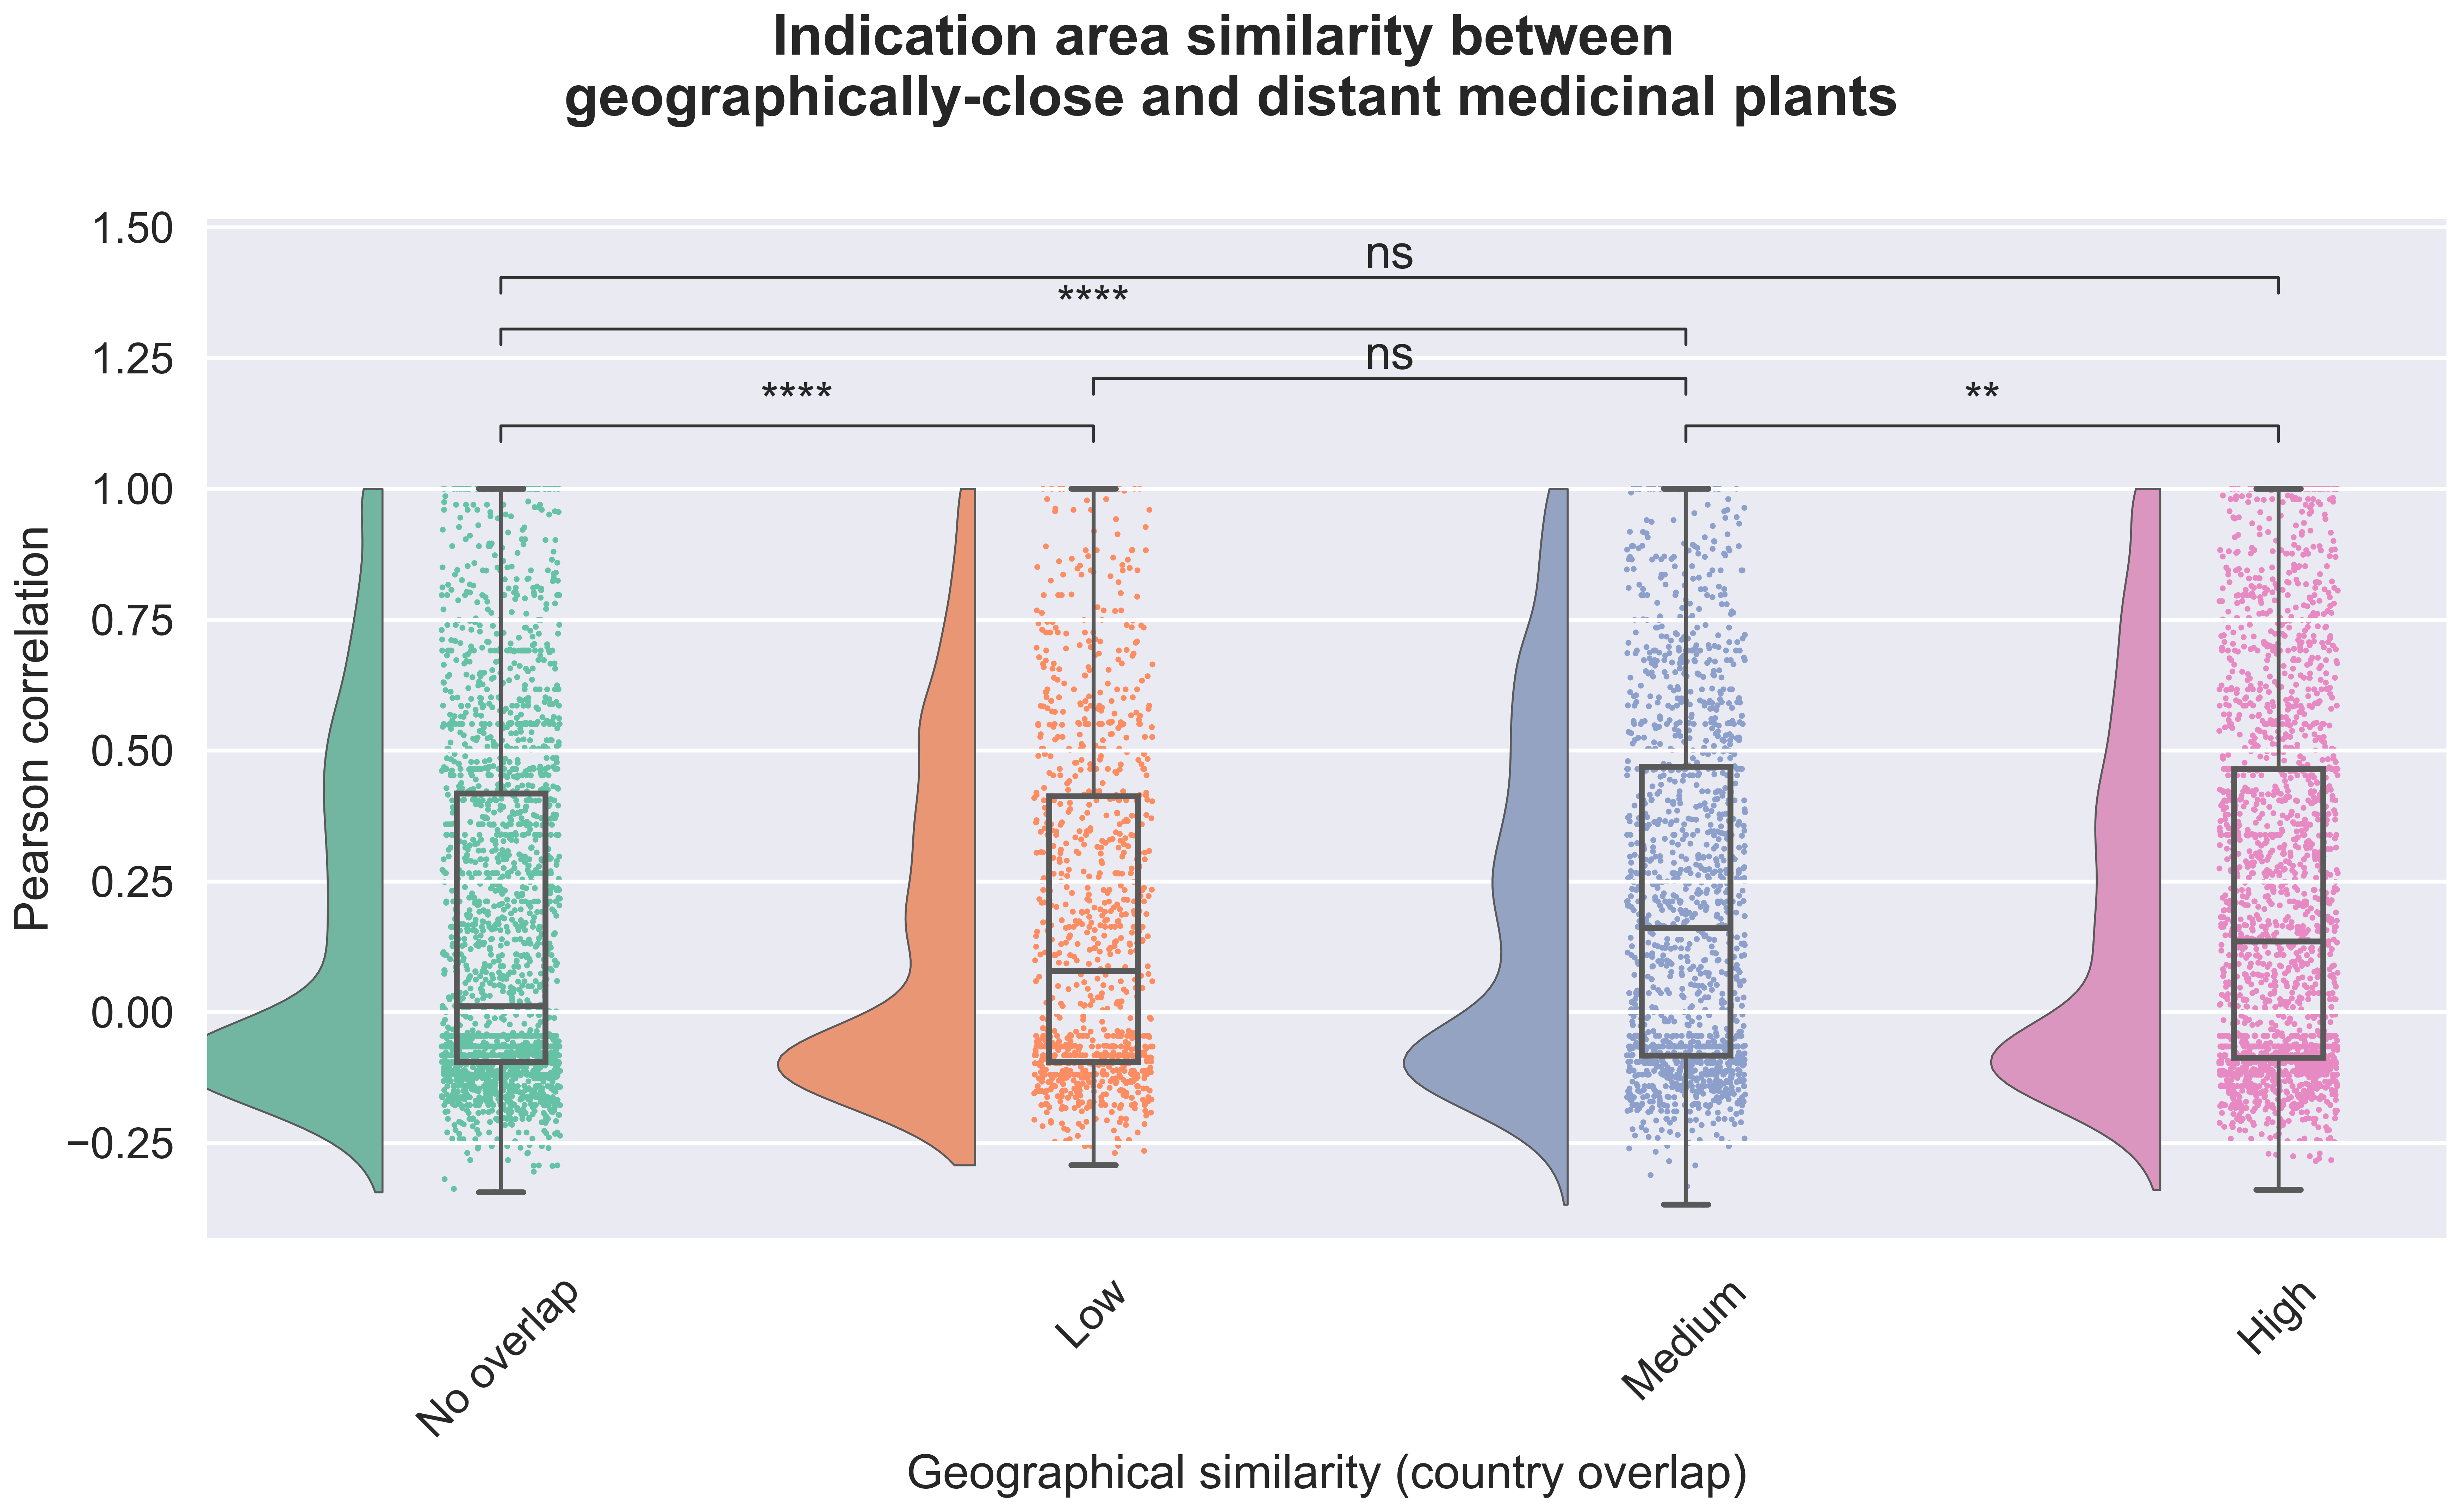

In [18]:
fig = plt.figure(figsize=(18, 11)) 
ax1 = fig.add_subplot(111)

suptitle = plt.suptitle(
    'Indication area similarity between \ngeographically-close and distant medicinal plants',
    y=0.99,
    fontweight='bold'
)

pt.RainCloud(
    data=merged_df,
    x='Geographical similarity (country overlap)',
    y='pearson_coefficient',
    ax=ax1,
    order=['No overlap', 'Low', 'Medium', 'High'],
)
add_stat_annotation(
    data=merged_df,
    x='Geographical similarity (country overlap)',
    y='pearson_coefficient',
    ax=ax1,
    box_pairs=[
        ("No overlap", "High"), ("No overlap", "Low"), ("Low", "Medium"), ("Medium", "High"), ("No overlap", "Medium"),
    ],
    test='Mann-Whitney',
    text_format='star', 
    line_offset=0,
    text_offset=0,
)

# Rotate ticks X
ax1.xaxis.set_tick_params(rotation=45)
ax1.set_ylabel("Pearson correlation")
    
plt.tight_layout()
plt.savefig(
    f'../data/figures/figure_3.png',
    dpi=400,
    bbox_inches='tight', 
    bbox_extra_artists=[suptitle],
)
plt.show()